# Modeling a DHN as a single pipe

![image](dhn_single_pipe.svg)

$\Delta T$ mean differences to ambient temperature $T_{env}$. 


\begin{equation*}
\dot{Q}_{prod} = c\dot{m} \hspace{3pt} (\Delta T_{prod,in} - \Delta T_{prod,r}) \\
\dot{Q}_{cons} = c\dot{m} \hspace{3pt} (\Delta T_{cons,r} - \Delta T_{cons,in}) \\
\dot{Q}_{loss,in} = c\dot{m} \hspace{3pt} (\Delta T_{cons,in} - \Delta T_{prod,in}) = c\dot{m} \Delta T_{prod,in} \hspace{3pt} exp \{-\frac{k\pi LD}{c\dot{m}}\}\\
\dot{Q}_{loss,r} = c\dot{m} \hspace{3pt} (\Delta T_{prod,r} - \Delta T_{cons,r}) = c\dot{m} \Delta T_{cons,r} \hspace{3pt} exp \{-\frac{k\pi LD}{c\dot{m}}\}\\
\dot{Q}_{prod} + \dot{Q}_{cons} + \dot{Q}_{loss,in} + \dot{Q}_{loss,r} = 0 \\
P_{el,pump} = \frac{1}{\eta}\frac{\Delta p }{\rho} \dot{m}
\end{equation*}

The following assumptions are made:
1. $\dot{Q}_{cons}$ is known
2. $\Delta T_{prod,in}$ is given by the Heizkurve
3. $\Delta T_{cons,in} - \Delta T_{cons,r} = \Delta T_{drop}$ is known

It follows from 1. that:

\begin{equation}
\dot{m} = \frac{\dot{Q}_{cons}}{c\Delta T_{drop}}.
\end{equation}

Together with 2., the mass flow is fixed. Next, the inlet temperature at the consumer is determined by:

\begin{equation}
\Delta T_{cons,in} = \Delta T_{prod,in} \hspace{3pt} exp \{-\frac{k\pi LD}{c\dot{m}}\}
\end{equation}

The return temperature at the consumer is given by 3. Again, the return temperature at the producer is reduced by losses on the return line:

\begin{equation}
\Delta T_{prod,r} = \Delta T_{cons,r} \hspace{3pt} exp \{-\frac{k\pi LD}{c\dot{m}}\}
\end{equation}

We are interested in $\dot{Q}_{prod}$. It can be determined by

\begin{equation}
\dot{Q}_{prod} = c\dot{m} (\Delta T_{prod,in} - \Delta T_{prod,r}).
\end{equation}

We insert above equations and finally get:

\begin{equation}
\dot{Q}_{prod} = \dot{Q}_{prod}(\dot{Q}_{cons}) = \dot{Q}_{cons} \frac{1}{\Delta T_{drop}}(\Delta T_{prod,in}(1- exp \{-2\frac{k\pi LD}{c\dot{m}}\}) + \Delta T_{drop} exp \{-\frac{k\pi LD}{c\dot{m}}\}) \\
P_{el,pump} = P_{el,pump}(\dot{Q}_{cons}) = 
\end{equation}

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
   
def single_pipe(Q_cons, DT_drop,
                DT_prod_in,
                k, L, D, c,
                rho, eps, mu):
    r"""
    
    
    """
    Q_cons *= 1e6 # MW to W
    
    # hydraulic part
    # mass flow is determined by consumer mass flow
    m = Q_cons * 1 /(c*DT_drop)
    
    # pressure loss
    v = 4*m / (rho * np.pi * D**2)
    Re = D * v * rho / mu
    print('re', Re)
    lamb = 1.325 / (np.log(eps/(3.7*D) + 5.74/(Re**0.9)))**2
    print('lamb', lamb)
    pressure_loss = lamb * 8 * L * 1/(rho*np.pi**2*D**5) * m**2
    Dp_pump = 2 * pressure_loss
    P_pump = Dp_pump * m * 1/rho

    # heat losses in feedin and return pipe
    exponent = k * np.pi * L * D * 1/(c*m)
    DT_cons_in = DT_prod_in * np.exp(-1*exponent)
    print('DT_cons_in', DT_cons_in)
    DT_prod_r = (DT_cons_in - DT_drop) *  np.exp(-1*exponent)
    print('DT_prod_r', DT_prod_r)
    
    Q_prod = c * m * (DT_prod_in - DT_prod_r)
    Q_loss = Q_prod - Q_cons
    
    if DT_prod_r > 0:
        return {'Q_prod': Q_prod, # W
                'DT_cons_in': DT_cons_in, # K
                'DT_prod_r': DT_prod_r, # K
                'm': m, # kg/s
                'pressure_loss': pressure_loss, # Pa
                'P_pump': P_pump, # W
                'Q_loss': Q_loss} # W
    else:
        return None

Rohrdurchmesser und Beschaffenheit, Druckverluste, Massenstrom und Pumpleistung



In [79]:
DT_prod_in = 110 # Kelvin, from Heizkurve
DT_drop = 10 # Kelvin
k = 1.5 # W/(m^2 * K) 
L = 1000 #m 
c = 4230 # J/(kg*K) at 20°C
rho = 951 # kg/m3
eps = 0.01*1e-3 #m
mu = 0.255e-3 

D = 0.25 # m

# Verschiedene Wärmenachfragen
dic = {'Q_cons [MW]': np.arange(1, 6, 0.2),
      'pressure_loss [bar]': [],
      'mass_flow [kg/s]': [],
      'Q_prod [MW]': [],
      'Q_loss [MW]': [],
      'P_pump [kW]': []}

for q in dic['Q_cons [MW]']:
    results = single_pipe(q, DT_drop, DT_prod_in,
                          k, L, D, c, rho, eps, mu)
    
    dic['pressure_loss [bar]'].append(results['pressure_loss'] * 1e-5)
    dic['P_pump [kW]'].append(results['P_pump'] * 1e-3)
    dic['mass_flow [kg/s]'].append(results['m'])
    dic['Q_prod [MW]'].append(results['Q_prod'] * 1e-6)
    dic['Q_loss [MW]'].append(results['Q_loss'] * 1e-6)

df = pd.DataFrame(dic)
df = df.set_index('Q_cons [MW]')

df['velocity_flow [m/s]'] = 4  * df['mass_flow [kg/s]'] / (rho * np.pi * D**2)
df['loss_perc'] = df['Q_loss [MW]'] * 1/df['Q_prod [MW]']
df

re 472160.4022565847
lamb 0.013809396368399625
DT_cons_in 108.71169666385805
DT_prod_r 97.55560022632822
re 566592.4827079016
lamb 0.013449830483797151
DT_cons_in 108.92536127720537
DT_prod_r 97.95891560543325
re 661024.5631592186
lamb 0.013166108687735378
DT_cons_in 109.0782359171918
DT_prod_r 98.24799265122395
re 755456.6436105354
lamb 0.012934876900461245
DT_cons_in 109.19303268349208
DT_prod_r 98.46534599802952
re 849888.7240618523
lamb 0.012741807057275957
DT_cons_in 109.28240257725793
DT_prod_r 98.63472261168447
re 944320.8045131692
lamb 0.012577535932593186
DT_cons_in 109.35395115415072
DT_prod_r 98.77042837711704
re 1038752.884964486
lamb 0.012435642017406285
DT_cons_in 109.41252573996654
DT_prod_r 98.8815957399925
re 1133184.9654158032
lamb 0.012311549842812844
DT_cons_in 109.461361861127
DT_prod_r 98.97432838073927
re 1227617.0458671201
lamb 0.012201896679485418
DT_cons_in 109.50270175809173
DT_prod_r 99.05286067946062
re 1322049.1263184373
lamb 0.012104146857192735
DT_cons_i

,pressure_loss [bar],mass_flow [kg/s],Q_prod [MW],Q_loss [MW],P_pump [kW],velocity_flow [m/s],loss_perc
Q_cons [MW],,,,,,,
1.0,0.067360,23.640662,1.244440,0.244440,0.334898,0.506418,0.196426
1.2,0.094473,28.368794,1.444930,0.244930,0.563636,0.607702,0.169510
1.4,0.125876,33.096927,1.645281,0.245281,0.876152,0.708985,0.149082
1.6,0.161522,37.825059,1.845545,0.245545,1.284873,0.810269,0.133047
1.8,0.201375,42.553191,2.045750,0.245750,1.802132,0.911553,0.120127
2.0,0.245406,47.281324,2.245914,0.245914,2.440190,1.012836,0.109494
2.2,0.293591,52.009456,2.446049,0.246049,3.211251,1.114120,0.100590
2.4,0.345911,56.737589,2.646161,0.246161,4.127476,1.215403,0.093026
2.6,0.402349,61.465721,2.846256,0.246256,5.200983,1.316687,0.086519


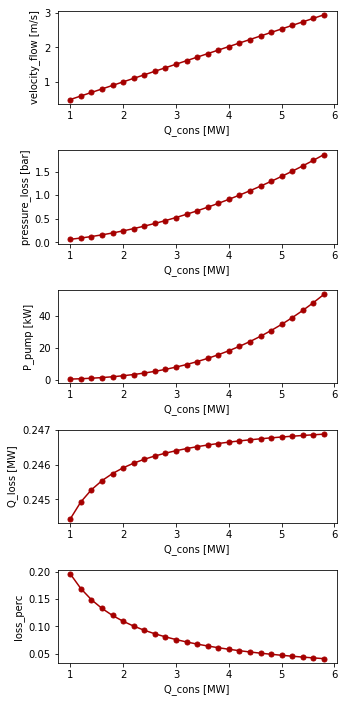

In [80]:
fig, axs = plt.subplots(5, 1, figsize=(5,12))
for i, c in enumerate(['velocity_flow [m/s]',
                       'pressure_loss [bar]',
                       'P_pump [kW]',
                       'Q_loss [MW]',
                       'loss_perc',]):
    df[c].plot(ax=axs[i], marker='.',
               markersize=10, color='#a50000')
    axs[i].set_xlabel('Q_cons [MW]')
    axs[i].set_ylabel(c)
plt.subplots_adjust(hspace=0.5)
fig.savefig('single_pipe.pdf')

Temperaturspreizung

Wärmeverluste

Kosten (Pumpkosten + Wärmekosten)

Bei versch. Außentemperaturen  
Bei verschiedenen Temperaturniveaus

# Test different formulas for the Colebrook eqn.

e/d 4e-05


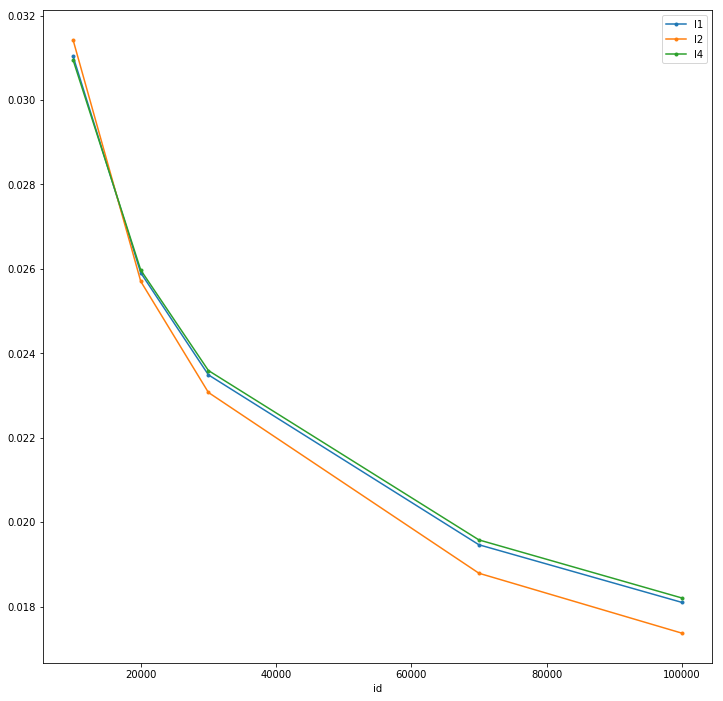

In [59]:
from scipy.optimize import root

eps = 0.01*1e-3
D = 0.25
print('e/d', eps/D)

lam = {'id': [],
       'l0': [],
       'l1': [],
       'l2': [],
       'l3': [],
       'l4': []}

for Re in ([10000,20000,30000,70000,100000]):
    lamb0 = 0.07 * Re**(-0.13) * D**(-0.14)
    lamb1 = 1.325 / (np.log(eps/(3.7*D) + 5.74/(Re**0.9)))**2
    lamb2 = 0.25 * 1/(np.log10(15/Re + eps/(3.715*D)))**2
    lamb3 = 0.25 / (np.log10(eps/(3.7*D) + 5.74/(Re**0.9)))**2
    
    def f(x):
        return (-2*np.log10((2.51/(Re*np.sqrt(x))) + (eps/(3.71*D))) - 1.0/np.sqrt(x))
    lamb4 = root(f, 0.0002)['x'][0]
    
    lam['id'].append(Re)
    lam['l0'].append(lamb0)
    lam['l1'].append(lamb1)
    lam['l2'].append(lamb2)
    lam['l3'].append(lamb3)
    lam['l4'].append(lamb4)
ll = pd.DataFrame(lam)
ll = ll.set_index('id')
fig, ax = plt.subplots(figsize=(12,12))
ll[['l1', 'l2', 'l4']].plot(marker='.', ax=ax)

# Test pipe data

In [61]:
df = pd.DataFrame()
df['DN'] = np.array([0.025, 0.032, 0.040, 0.050, 0.160])
df['Uspez'] = np.array([0.264, 0.312, 0.322, 0.341, 0.511])
df['U'] = df['Uspez'] * 1/(2* np.pi * df['DN'])

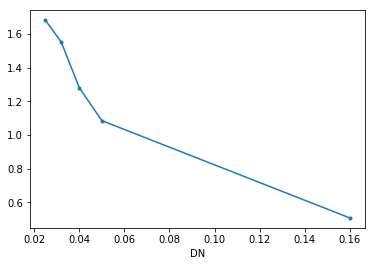

In [62]:
df = df.set_index('DN')
df['U'].plot(marker='.')

# Multidimension plot

In [82]:
lamb_func = lambda eps, D, Re: 1.325 / (np.log(eps/(3.7*D) + 5.74/(Re**0.9)))**2

def single_pipe(args):
    r"""
    
    
    """
    Q_cons, DT_drop, DT_prod_in, k, L, D, c, rho, eps, mu = args
    Q_cons *= 1e6 # MW to W
    
    # hydraulic part
    # mass flow is determined by consumer mass flow
    m = Q_cons * 1 /(c*DT_drop)
    
    # pressure loss
    v = 4*m / (rho * np.pi * D**2)
    Re = D * v * rho / mu
    lamb = lamb_func(eps, D, Re)
    
    pressure_loss = lamb * 8*L * 1/(rho*np.pi**2*D**5) * m**2
    Dp_pump = 2 * pressure_loss
    P_pump = Dp_pump * m * 1/rho

    # heat losses in feedin and return pipe
    exponent = k * np.pi * L * D * 1/(c*m)
    DT_cons_in = DT_prod_in * np.exp(-1*exponent)
    DT_prod_r = (DT_cons_in - DT_drop) *  np.exp(-1*exponent)
    
    Q_prod = c * m * (DT_prod_in - DT_prod_r)
    Q_loss = Q_prod - Q_cons
    perc_loss = Q_loss * 1/Q_prod
    
    # Change units
    pressure_loss_bar = 1e-5 * pressure_loss
    P_pump_kW = 1e-3 * P_pump
    Q_loss_MW = 1e-6 * Q_loss
    
    
    if DT_prod_r > 0:
        return np.array([Q_prod, DT_cons_in, DT_prod_r, v, 
                         pressure_loss_bar, P_pump_kW, Q_loss_MW, perc_loss])
    else:
        return None

In [83]:
def generic_sampling(input_dict, results_dict, function):
    r"""
    n-dimensional full sampling, storing as xarray.
    
    Parameters
    ----------
    input_dict : OrderedDict
        Ordered dictionary containing the ranges of the
        dimensions.
    
    results_dict : OrderedDict
        Ordered dictionary containing the dimensions and 
        coordinates of the results of the function.
        
    function : function
        Function to be sampled.
    
    Returns
    -------
    results : xarray.DataArray
    
    sampling : np.array
    
    indices : 
    """
    import itertools as it
    join_dicts = OrderedDict(list(input_dict.items()) + list(results_dict.items()))
    dims = join_dicts.keys()
    coords = join_dicts.values()
    results = xr.DataArray(np.empty([len(v) for v in join_dicts.values()]),
                           dims=dims,
                           coords=coords)

    sampling = np.array(list(it.product(*input_dict.values())))
    indices = np.array(list(it.product(*[np.arange(len(v)) for v in input_dict.values()])))
    
    for i in range(len(sampling)):
        result = function(sampling[i])
        results[tuple(indices[i])] = result
        
    return results, sampling, indices

from collections import OrderedDict
import xarray as xr

input_dict = OrderedDict([('Q_cons', np.arange(1, 6, 0.2)),
                          ('DT_drop', [10]),
                          ('DT_prod_in', [70,80,90,100,110]),
                          ('k', np.arange(1, 4, 0.1)),
                          ('L', [1000]),
                          ('D', [0.25, 0.25001]),
                          ('c', [4230]),
                          ('rho', [951]),
                          ('eps', [0.01e-3]),
                          ('mu', [0.255e-3])])

result_dict_scalar = OrderedDict()

result_dict_vector = OrderedDict([('results', ['Q_prod',
                                               'DT_cons_in',
                                               'DT_prod_r',
                                               'v [m/s]',
                                               'pressure_loss [bar]',
                                               'P_pump [kW]',
                                               'Q_loss [MW]',
                                               'loss [%]'])])

result_dict_array = OrderedDict([('time', np.arange(0,8,2)),
                                ('lat', np.arange(0,8,4))])

result_dict_cube = OrderedDict([('time', np.arange(0,9,3)),
                                ('lat', np.arange(0,8,2)),
                                ('lon', np.arange(0,15,3))])

sam_results = generic_sampling(input_dict, result_dict_vector, 
                          single_pipe)[0]

In [84]:
sam_results.coords

Coordinates:
  * Q_cons      (Q_cons) float64 1.0 1.2 1.4 1.6 1.8 2.0 ... 5.0 5.2 5.4 5.6 5.8
  * DT_drop     (DT_drop) int64 10
  * DT_prod_in  (DT_prod_in) int64 70 80 90 100 110
  * k           (k) float64 1.0 1.1 1.2 1.3 1.4 1.5 ... 3.4 3.5 3.6 3.7 3.8 3.9
  * L           (L) int64 1000
  * D           (D) float64 0.25 0.25
  * c           (c) int64 4230
  * rho         (rho) int64 951
  * eps         (eps) float64 1e-05
  * mu          (mu) float64 0.000255
  * results     (results) <U19 'Q_prod' 'DT_cons_in' ... 'loss [%]'

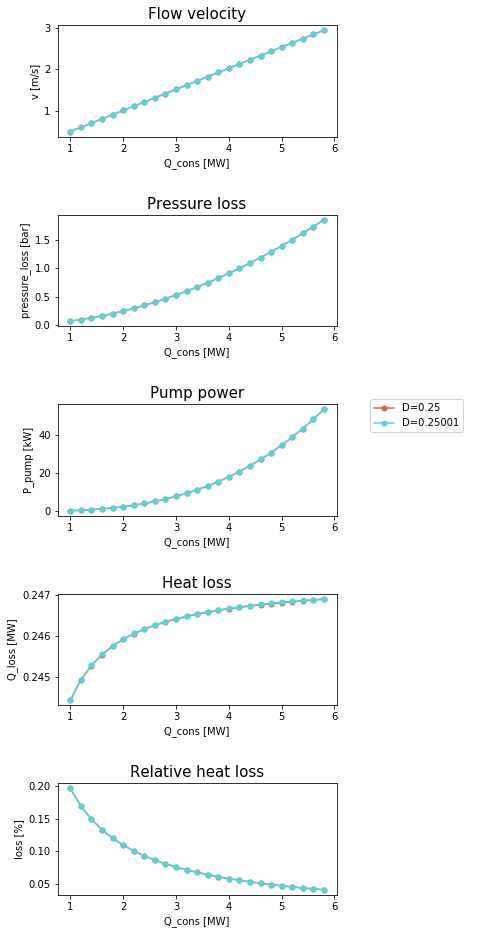

In [85]:
import seaborn as sns
import matplotlib

fig, axs = plt.subplots(5, 1, figsize=(5,16))

colors = sns.color_palette("hls", len(sam_results['D'])).as_hex()
titles = ['Flow velocity', 'Pressure loss', 'Pump power',
          'Heat loss', 'Relative heat loss']

for i, c in enumerate(['v [m/s]',
                       'pressure_loss [bar]',
                       'P_pump [kW]',
                       'Q_loss [MW]',
                       'loss [%]']):
#     for i_k in [0, 1, 2]:
#         sam_results.squeeze() \
#         .isel(k=i_k, D=1, DT_prod_in=-1) \
#         .sel(results=c) \
#         .plot(ax=axs[i], marker='.', markersize=10, color='#a50000')
        
    for ii, vv in enumerate(sam_results.coords['D'].values):
        sam_results.squeeze() \
        .isel(k=5, DT_prod_in=-1) \
        .sel(results=c, D=vv) \
        .plot(ax=axs[i], marker='.',
              markersize=10, color=colors[ii])

    axs[i].set_xlabel('Q_cons [MW]')
    axs[i].set_ylabel(c)
    axs[i].set_title(titles[i], size='15')
plt.subplots_adjust(hspace=0.7)
labels = [f'D={D}' for D in sam_results.coords['D'].values]
fig.legend(axs, labels=labels, loc = 'center right',  
           bbox_to_anchor=(1.3, 0.45), ncol=1)